In [1]:
import numpy as np
import xarray as xr
import glob
import matplotlib
import matplotlib.pyplot as plt
import cftime
import dask
import os
import statsmodels.api as sm
from scipy import stats
from sklearn import linear_model
%matplotlib inline

In [4]:
#for use on Casper: ONLY RUN THIS CELL ONCE  
#   note you may need to change the project number
ncores = 36
nmem   = str(int(375*ncores/36))+'GB'
from dask_jobqueue import SLURMCluster
from dask.distributed import Client
cluster = SLURMCluster(cores=ncores,
                     processes=ncores, memory=nmem,
                     project='P93300641',
                     walltime='3:00:00')
cluster.scale(ncores)
client = Client(cluster)

/glade/work/djk2120/miniconda3/envs/lens-py/lib/python3.7/site-packages/distributed/node.py:155: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 42582 instead
  http_address["port"], self.http_server.port


In [8]:
client

Client Scheduler: tcp://10.12.205.11:44849 Dashboard: http://10.12.205.11:42582/status,Cluster Workers: 36 Cores: 36 Memory: 375.12 GB


In [97]:
# colorbrewer colormap, diverging, brown->green
ccc = np.zeros([11,3]);
ccc[0,:] = 84,48,5
ccc[1,:] = 140,81,10
ccc[2,:] = 191,129,45
ccc[3,:] = 223,194,125
ccc[4,:] = 246,232,195
ccc[5,:] = 245,245,245
ccc[6,:] = 199,234,229
ccc[7,:] = 128,205,193
ccc[8,:] = 53,151,143
ccc[9,:] = 1,102,94
ccc[10,:] = 0,60,48
ccc = matplotlib.colors.ListedColormap(ccc/256)

In [2]:
def month_wts(nyears):
    days_pm  = [31,28,31,30,31,30,31,31,30,31,30,31]
    return xr.DataArray(np.tile(days_pm,nyears),dims='time')

In [3]:
members = ['OAAT'+str(i).zfill(4) for i in range(35)]
members.remove('OAAT0003')

In [27]:
thedir = '/glade/scratch/djk2120/clm5ppe/ens002/histSTEP3/'
thefiles = [glob.glob(thedir+'*'+member+'*.h0.*')[0] for member in members]
step3 = xr.open_mfdataset(thefiles,combine='nested',concat_dim='ens')

In [4]:
thedir = '/glade/scratch/djk2120/clm5ppe/ens002/histSTEP4/'
thefiles = [glob.glob(thedir+'*'+member+'*.h0.*')[0] for member in members]
step4 = xr.open_mfdataset(thefiles,combine='nested',concat_dim='ens')

In [5]:
thedir = '/glade/scratch/djk2120/clm5ppe/ens002/hist/'
thefiles = [glob.glob(thedir+'*'+member+'*.h0.*')[0] for member in members]
prod = xr.open_mfdataset(thefiles,combine='nested',concat_dim='ens')
nmonths = len(prod.time)
yr0 = prod['time.year'][0].values
prod['time'] =xr.cftime_range(str(yr0),periods=nmonths,freq='MS')

In [6]:
t = step4['time.year']
x1 = step4.TOTECOSYSC.isel(time=t>31).mean(dim='time').values
x2 = (month_wts(10)/365*prod.TOTECOSYSC).groupby('time.year').sum().mean(dim='year').values

In [7]:
la = xr.open_dataset('sparsegrid_landarea.nc').landarea.values

0.3482977637554781
0.14100777977582254
0.07850355314885626


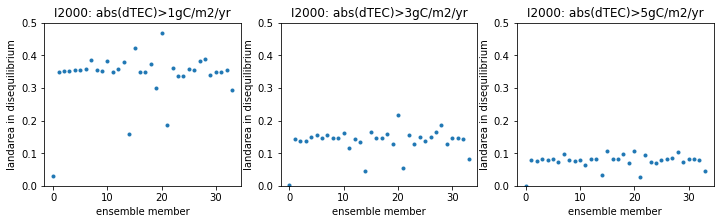

In [8]:
plt.figure(figsize=[12,3])
i=0
for thresh in [1,3,5]:
    i+=1
    ix = abs(x2-x1)>10*thresh
    la_diseq = (ix*la).sum(axis=1)
    diseq = la_diseq/np.nansum(la)
    print(diseq[1:].mean())
    plt.subplot(1,3,i)
    plt.plot(diseq,'.')
    plt.ylim([0,0.5])
    plt.xlabel('ensemble member')
    plt.ylabel('landarea in disequilibrium')
    plt.title('I2000: abs(dTEC)>'+str(thresh)+'gC/m2/yr')

In [10]:
thedir = '/glade/scratch/djk2120/stemleaf_step4/run/'
file   = glob.glob(thedir+'*.h0.*')[0]
stemleaf = xr.open_dataset(file)

In [23]:
t = stemleaf['time.year']
ixt = np.logical_and(t>21,t<=31)
tec1 = stemleaf.TOTECOSYSC.isel(time=ixt).mean(dim='time').values
tec2 = stemleaf.TOTECOSYSC.isel(time=t>31).mean(dim='time').values
dtec = abs(tec2-tec1)
ix   = dtec>10
la_diseq = (ix*la).sum()
diseq = la_diseq/np.nansum(la)
diseq

0.052903258976277075

In [25]:
thedir = '/glade/scratch/djk2120/q10mr_step4/run/'
file   = glob.glob(thedir+'*.h0.*')[0]
q10mr  = xr.open_dataset(file)

In [26]:
t = stemleaf['time.year']
ixt = np.logical_and(t>21,t<=31)
tec1 = q10mr.TOTECOSYSC.isel(time=ixt).mean(dim='time').values
tec2 = q10mr.TOTECOSYSC.isel(time=t>31).mean(dim='time').values
dtec = abs(tec2-tec1)
ix   = dtec>10
la_diseq = (ix*la).sum()
diseq = la_diseq/np.nansum(la)
diseq

0.21060905660762516

In [40]:
tec = step4.TOTECOSYSC+step4.TOTSOMC_1m-step4.TOTSOMC
x1 = tec.isel(time=t>31).mean(dim='time').values
tec = prod.TOTECOSYSC+prod.TOTSOMC_1m-prod.TOTSOMC
x2 = (month_wts(10)/365*tec).groupby('time.year').sum().mean(dim='year').values

In [48]:
ix = abs(x2-x1)>50
la_diseq = (ix*la).sum(axis=1)
diseq = la_diseq/np.nansum(la)
(diseq>0.1).sum()

3

0.34825675589406213
0.14006654501671378
0.07814836818932938


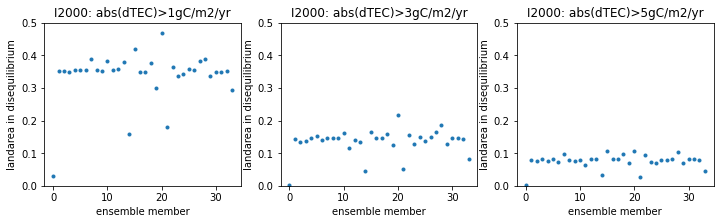

In [41]:
plt.figure(figsize=[12,3])
i=0
for thresh in [1,3,5]:
    i+=1
    ix = abs(x2-x1)>10*thresh
    la_diseq = (ix*la).sum(axis=1)
    diseq = la_diseq/np.nansum(la)
    print(diseq[1:].mean())
    
    plt.subplot(1,3,i)
    plt.plot(diseq,'.')
    plt.ylim([0,0.5])
    plt.xlabel('ensemble member')
    plt.ylabel('landarea in disequilibrium')
    plt.title('I2000: abs(dTEC)>'+str(thresh)+'gC/m2/yr')

In [49]:
t = step4['time.year']
x1 = step4.TOTVEGC.isel(time=t>31).mean(dim='time').values
x2 = (month_wts(10)/365*prod.TOTVEGC).groupby('time.year').sum().mean(dim='year').values

In [50]:
ix = abs(x2-x1)>10
la_diseq = (ix*la).sum(axis=1)
diseq = la_diseq/np.nansum(la)

0.07866081991625833
0.02253266835323968
0.008634685434033082


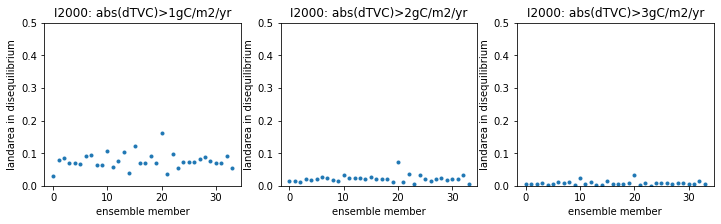

In [52]:
plt.figure(figsize=[12,3])
i=0
for thresh in [1,2,3]:
    i+=1
    ix = abs(x2-x1)>10*thresh
    la_diseq = (ix*la).sum(axis=1)
    diseq = la_diseq/np.nansum(la)
    print(diseq[1:].mean())
    
    plt.subplot(1,3,i)
    plt.plot(diseq,'.')
    plt.ylim([0,0.5])
    plt.xlabel('ensemble member')
    plt.ylabel('landarea in disequilibrium')
    plt.title('I2000: abs(dTVC)>'+str(thresh)+'gC/m2/yr')

### global values

In [30]:
t3 = step3['time.year']
t4 = step4['time.year']

In [57]:
params =['default','taulnir', 'dleaf', 'tkd_sand', 'bsw_sf', 'n_melt_coef', 'medlynslope', 
         'jmaxb1', 'kmax', 'dbh', 'grperc', 'FUN_fracfixers', 
         'froot_leaf', 'leaf_long', 'tau_cwd', 'k_nitr_max_perday', 'cli_scale', 'vcmaxha']
p2 = []
for p in params:
    if (p=='dleaf'):
        p2.append('dleaf-hi')
    elif (p=='default'):
        p2.append(p)
    else:
        p2.append(p+'-lo')
        p2.append(p+'-hi')

In [55]:
tec3 = 1e-9*(la*step3.TOTECOSYSC.isel(time=t3>1)).sum(dim='gridcell').compute()
tec4 = 1e-9*(la*step4.TOTECOSYSC.isel(time=t4>1)).sum(dim='gridcell').compute()
tec  = 1e-9*(la*(month_wts(10)/365*prod.TOTECOSYSC).groupby('time.year').sum()).sum(dim='gridcell').compute()

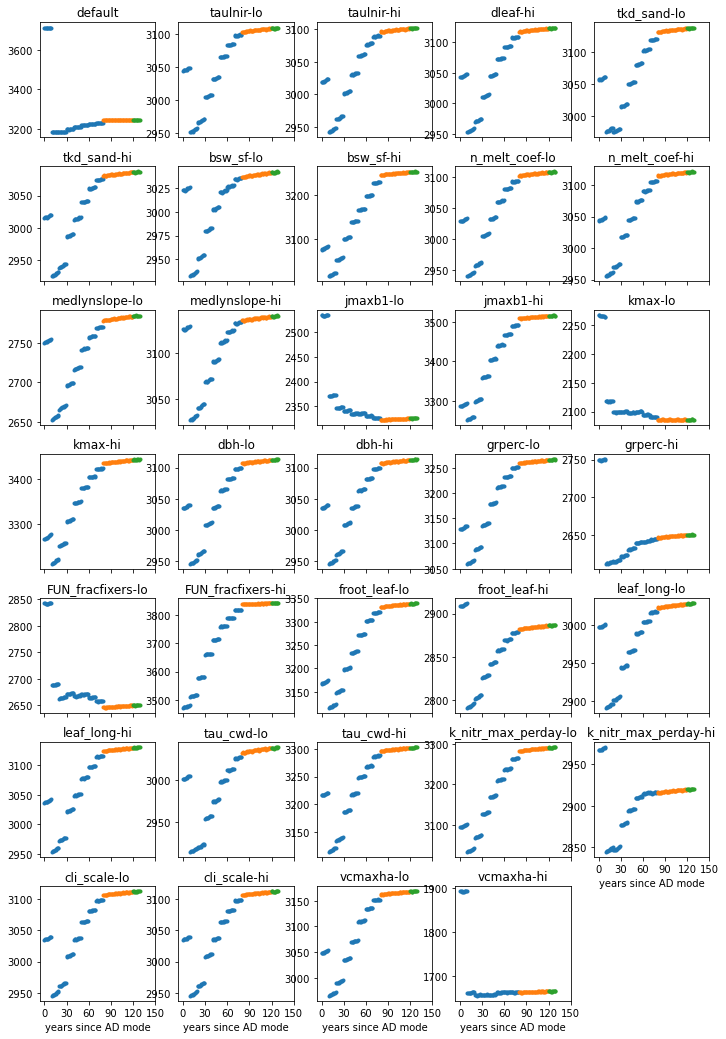

In [62]:
plt.figure(figsize=[12,18])
i=0
for ee in prod.ens.values:
    i +=1
    plt.subplot(7,5,i)
    plt.plot(np.arange(80),tec3.sel(ens=ee),'.')
    plt.plot(80+np.arange(40),tec4.sel(ens=ee),'.')
    plt.plot(120+np.arange(10),tec.sel(ens=ee),'.')
    plt.title(p2[ee])
    if i>29:
        plt.xlabel('years since AD mode')
        plt.xticks(30*np.arange(6))
    else:
        plt.xticks(30*np.arange(6),'')
plt.subplots_adjust(hspace=0.25)

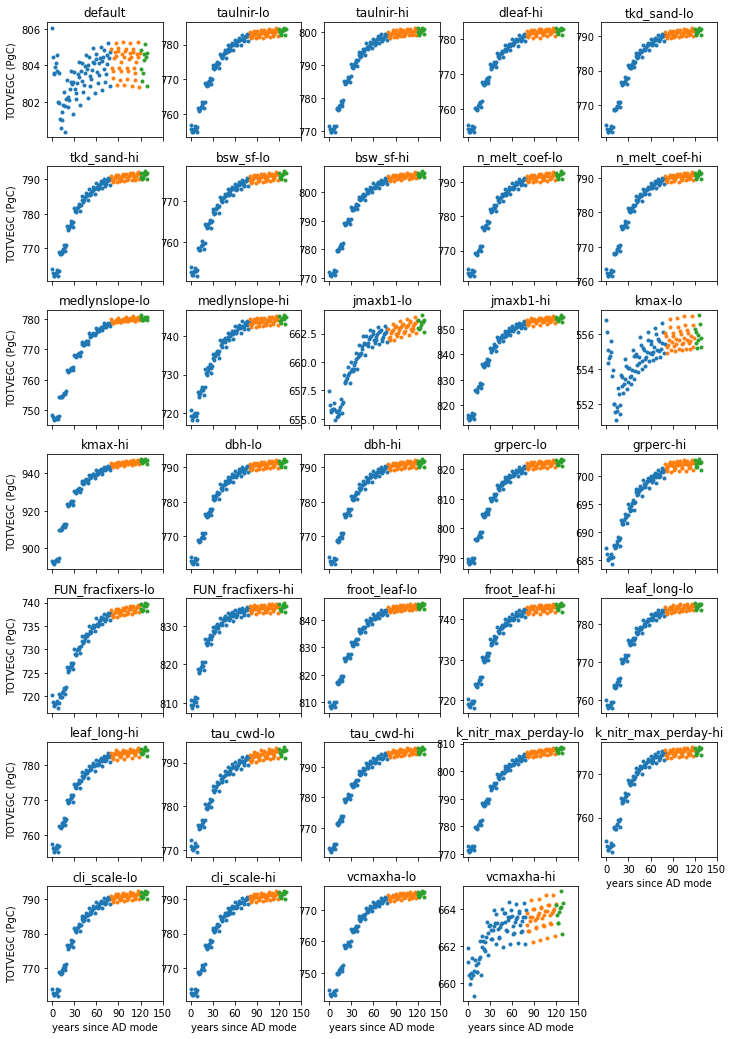

In [65]:
tvc3 = 1e-9*(la*step3.TOTVEGC.isel(time=t3>1)).sum(dim='gridcell').compute()
tvc4 = 1e-9*(la*step4.TOTVEGC.isel(time=t4>1)).sum(dim='gridcell').compute()
tvc  = 1e-9*(la*(month_wts(10)/365*prod.TOTVEGC).groupby('time.year').sum()).sum(dim='gridcell').compute()
plt.figure(figsize=[12,18])
i=0
for ee in prod.ens.values:
    i +=1
    plt.subplot(7,5,i)
    plt.plot(np.arange(80)    ,tvc3.sel(ens=ee),'.')
    plt.plot(80+np.arange(40) ,tvc4.sel(ens=ee),'.')
    plt.plot(120+np.arange(10),tvc.sel(ens=ee),'.')
    plt.title(p2[ee])
    if i%5==1:
        plt.ylabel('TOTVEGC (PgC)')
    if i>29:
        plt.xlabel('years since AD mode')
        plt.xticks(30*np.arange(6))
    else:
        plt.xticks(30*np.arange(6),'')
plt.subplots_adjust(hspace=0.25)

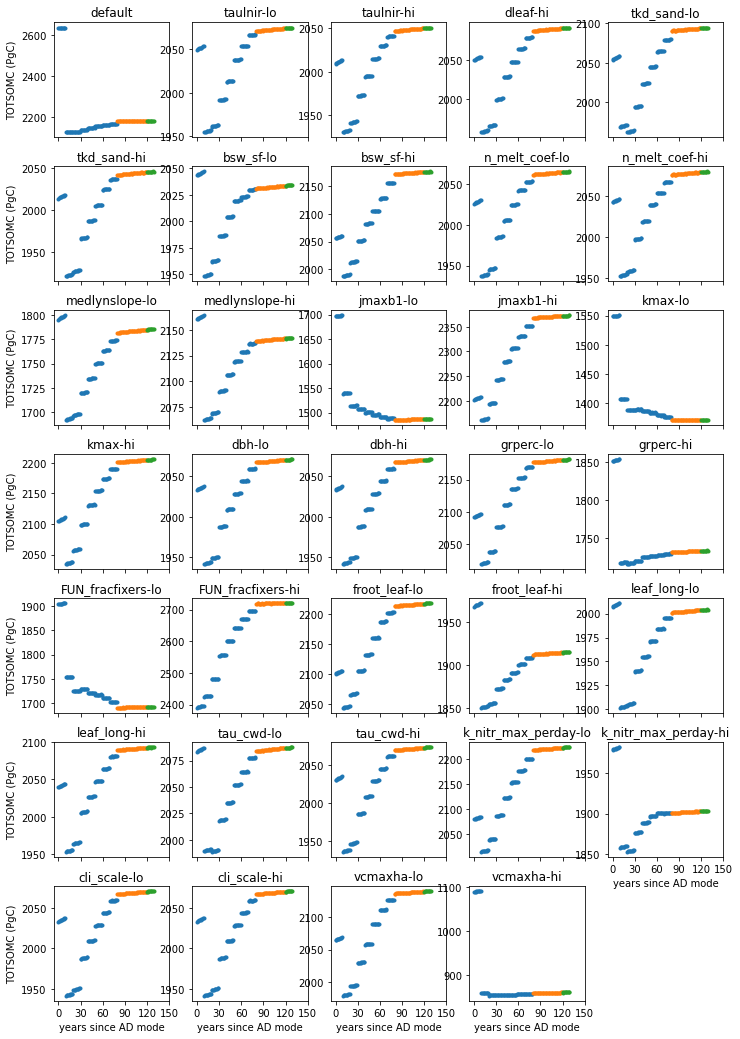

In [66]:
tsc3 = 1e-9*(la*step3.TOTSOMC.isel(time=t3>1)).sum(dim='gridcell').compute()
tsc4 = 1e-9*(la*step4.TOTSOMC.isel(time=t4>1)).sum(dim='gridcell').compute()
tsc  = 1e-9*(la*(month_wts(10)/365*prod.TOTSOMC).groupby('time.year').sum()).sum(dim='gridcell').compute()
plt.figure(figsize=[12,18])
i=0
for ee in prod.ens.values:
    i +=1
    plt.subplot(7,5,i)
    plt.plot(np.arange(80)    ,tsc3.sel(ens=ee),'.')
    plt.plot(80+np.arange(40) ,tsc4.sel(ens=ee),'.')
    plt.plot(120+np.arange(10),tsc.sel(ens=ee),'.')
    plt.title(p2[ee])
    if i%5==1:
        plt.ylabel('TOTSOMC (PgC)')
    if i>29:
        plt.xlabel('years since AD mode')
        plt.xticks(30*np.arange(6))
    else:
        plt.xticks(30*np.arange(6),'')
plt.subplots_adjust(hspace=0.25)

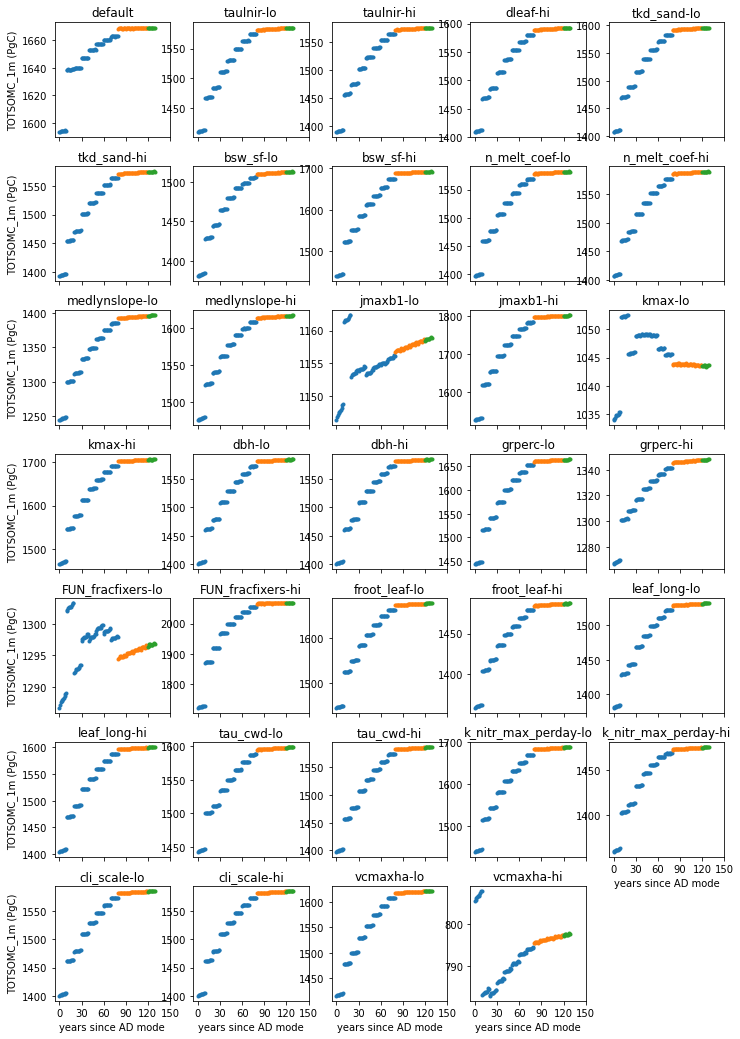

In [68]:
ts1c3 = 1e-9*(la*step3.TOTSOMC_1m.isel(time=t3>1)).sum(dim='gridcell').compute()
ts1c4 = 1e-9*(la*step4.TOTSOMC_1m.isel(time=t4>1)).sum(dim='gridcell').compute()
ts1c  = 1e-9*(la*(month_wts(10)/365*prod.TOTSOMC_1m).groupby('time.year').sum()).sum(dim='gridcell').compute()
plt.figure(figsize=[12,18])
i=0
for ee in prod.ens.values:
    i +=1
    plt.subplot(7,5,i)
    plt.plot(np.arange(80)    ,ts1c3.sel(ens=ee),'.')
    plt.plot(80+np.arange(40) ,ts1c4.sel(ens=ee),'.')
    plt.plot(120+np.arange(10),ts1c.sel(ens=ee),'.')
    plt.title(p2[ee])
    if i%5==1:
        plt.ylabel('TOTSOMC_1m (PgC)')
    if i>29:
        plt.xlabel('years since AD mode')
        plt.xticks(30*np.arange(6))
    else:
        plt.xticks(30*np.arange(6),'')
plt.subplots_adjust(hspace=0.25)

In [116]:
thedir = '/glade/scratch/oleson/archive/ctsm51c6_PPEn05cnmatrixn04ctsm51d023_2deg_GSWP3V1_Sparse400_fullout_2000pAD/lnd/hist/'
thefiles = sorted(glob.glob(thedir+'*.h0.*'))

In [118]:
ds = xr.open_mfdataset(thefiles[-12:],combine='by_coords')

In [120]:
(month_wts(1)/365*ds.TOTSOMC_1m)

<xarray.DataArray 'TOTSOMC_1m' (time: 12, lat: 96, lon: 144)>
dask.array<concatenate, shape=(12, 96, 144), dtype=float32, chunksize=(1, 96, 144), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 3120-02-01 00:00:00 ... 3121-01-01 00:00:00
  * lon      (lon) float32 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
  * lat      (lat) float32 -90.0 -88.11 -86.21 -84.32 ... 84.32 86.21 88.11 90.0
Attributes:
    long_name:     total soil organic matter carbon to 1 meter depth
    units:         gC/m^2
    cell_methods:  time: mean

In [114]:
file = '/glade/p/cgd/tss/people/oleson/CLM5_restarts/ctsm51c6_PPEn05cnmatrixn04ctsm51d023_2deg_GSWP3V1_Sparse400_fullout_2000pAD.clm2.r.3081-01-01-00000.nc'
ds = xr.open_dataset(file)

In [115]:
ds.TOTSOMC

AttributeError: 'Dataset' object has no attribute 'TOTSOMC'

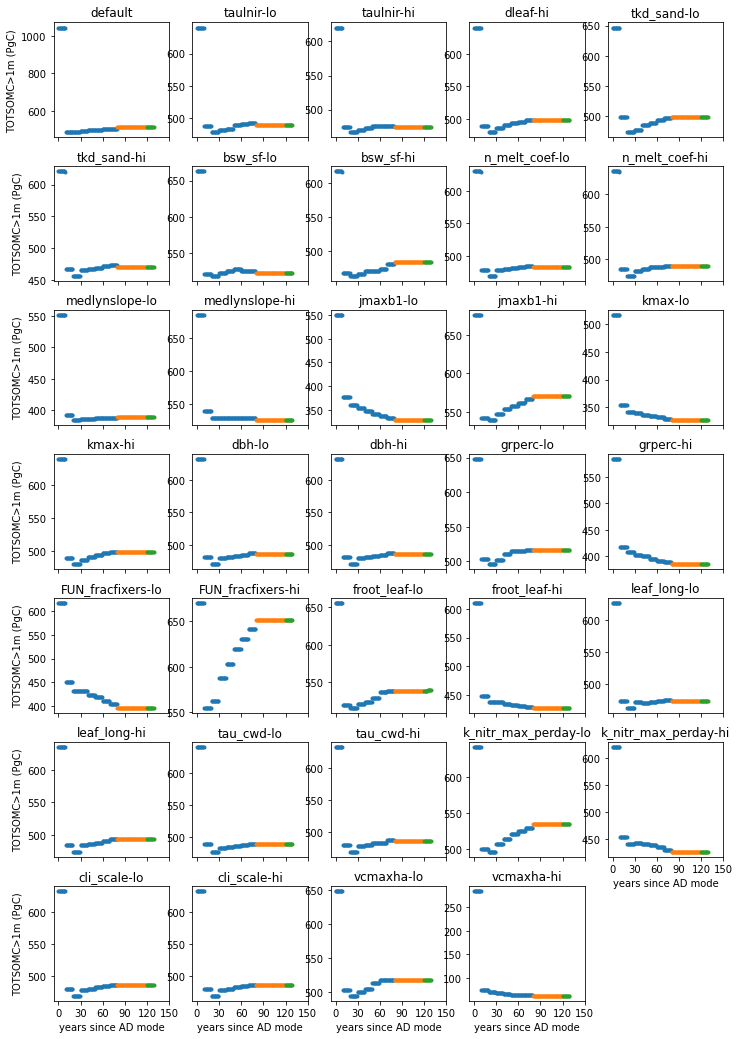

In [70]:
ts2c3 = 1e-9*(la*(step3.TOTSOMC-step3.TOTSOMC_1m).isel(time=t3>1)).sum(dim='gridcell').compute()
ts2c4 = 1e-9*(la*(step4.TOTSOMC-step4.TOTSOMC_1m).isel(time=t4>1)).sum(dim='gridcell').compute()
ts2c  = 1e-9*(la*(month_wts(10)/365*(prod.TOTSOMC-prod.TOTSOMC_1m)).groupby('time.year').sum()).sum(dim='gridcell').compute()
plt.figure(figsize=[12,18])
i=0
for ee in prod.ens.values:
    i +=1
    plt.subplot(7,5,i)
    plt.plot(np.arange(80)    ,ts2c3.sel(ens=ee),'.')
    plt.plot(80+np.arange(40) ,ts2c4.sel(ens=ee),'.')
    plt.plot(120+np.arange(10),ts2c.sel(ens=ee),'.')
    plt.title(p2[ee])
    if i%5==1:
        plt.ylabel('TOTSOMC>1m (PgC)')
    if i>29:
        plt.xlabel('years since AD mode')
        plt.xticks(30*np.arange(6))
    else:
        plt.xticks(30*np.arange(6),'')
plt.subplots_adjust(hspace=0.25)

In [81]:
gpp3 = 1e-9*365*24*60*60*(la*step3.GPP.isel(time=t3>1)).sum(dim='gridcell').compute()
gpp4 = 1e-9*365*24*60*60*(la*step4.GPP.isel(time=t4>1)).sum(dim='gridcell').compute()
gpp  = 1e-9*24*60*60*(la*(month_wts(10)*prod.GPP).groupby('time.year').sum()).sum(dim='gridcell').compute()\

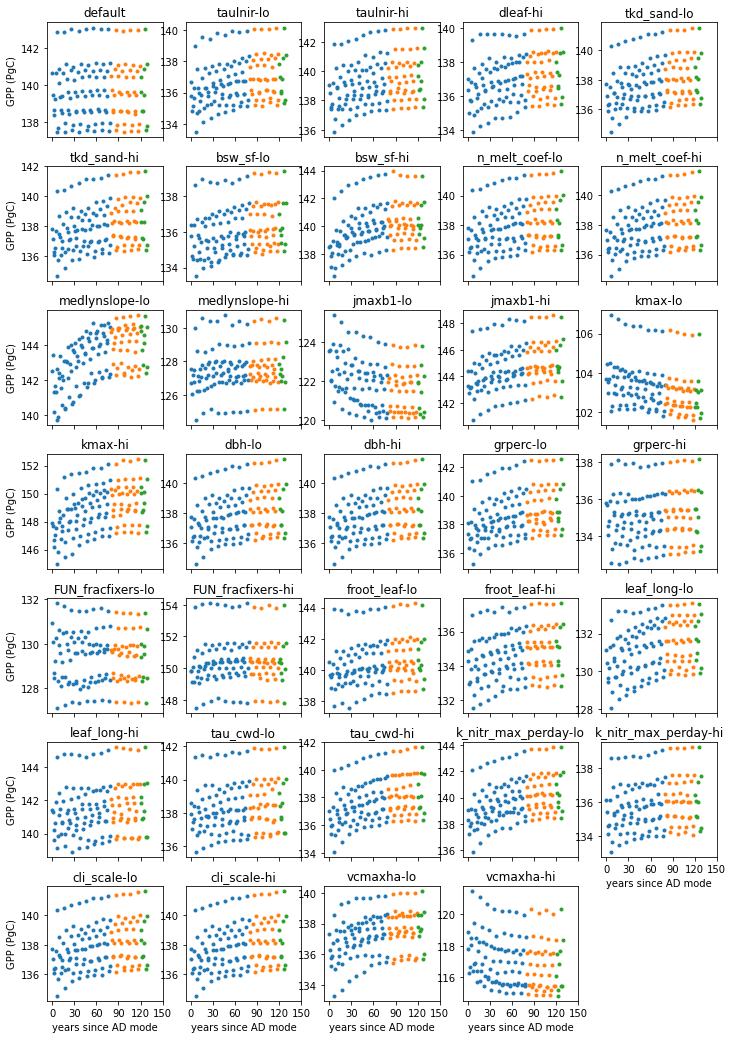

In [82]:
plt.figure(figsize=[12,18])
i=0
for ee in prod.ens.values:
    i +=1
    plt.subplot(7,5,i)
    plt.plot(np.arange(80)    ,gpp3.sel(ens=ee),'.')
    plt.plot(80+np.arange(40) ,gpp4.sel(ens=ee),'.')
    plt.plot(120+np.arange(10), gpp.sel(ens=ee),'.')
    plt.title(p2[ee])
    if i%5==1:
        plt.ylabel('GPP (PgC)')
    if i>29:
        plt.xlabel('years since AD mode')
        plt.xticks(30*np.arange(6))
    else:
        plt.xticks(30*np.arange(6),'')
plt.subplots_adjust(hspace=0.25)

In [83]:
npp3 = 1e-9*365*24*60*60*(la*step3.NPP.isel(time=t3>1)).sum(dim='gridcell').compute()
npp4 = 1e-9*365*24*60*60*(la*step4.NPP.isel(time=t4>1)).sum(dim='gridcell').compute()
npp  = 1e-9*24*60*60*(la*(month_wts(10)*prod.NPP).groupby('time.year').sum()).sum(dim='gridcell').compute()\

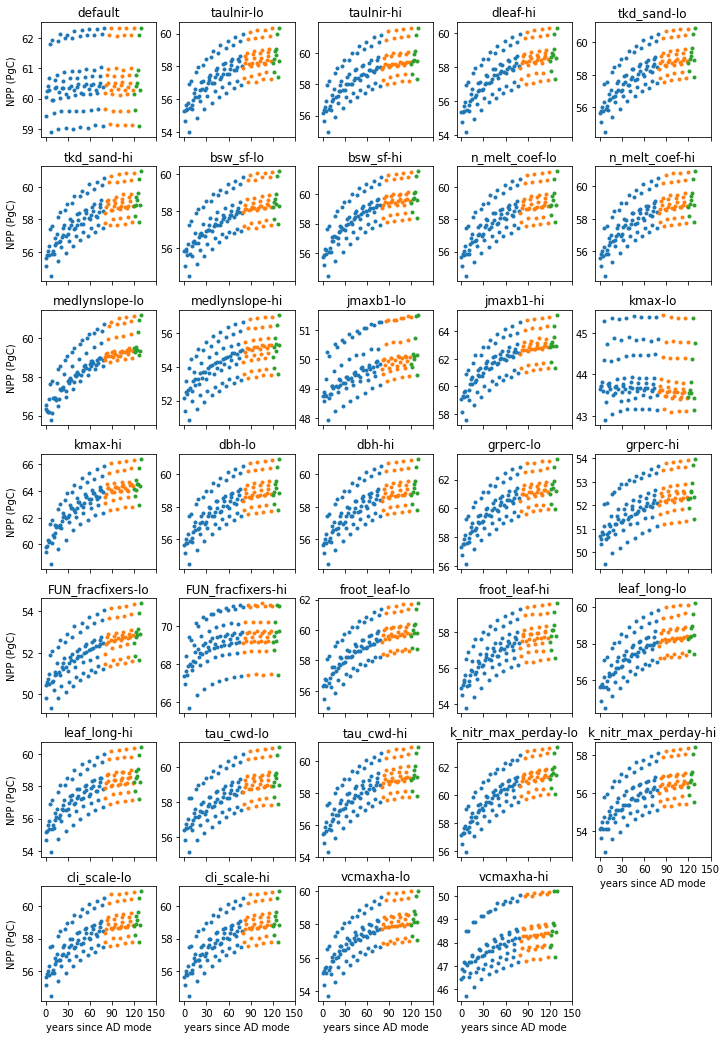

In [84]:
plt.figure(figsize=[12,18])
i=0
for ee in prod.ens.values:
    i +=1
    plt.subplot(7,5,i)
    plt.plot(np.arange(80)    ,npp3.sel(ens=ee),'.')
    plt.plot(80+np.arange(40) ,npp4.sel(ens=ee),'.')
    plt.plot(120+np.arange(10), npp.sel(ens=ee),'.')
    plt.title(p2[ee])
    if i%5==1:
        plt.ylabel('NPP (PgC)')
    if i>29:
        plt.xlabel('years since AD mode')
        plt.xticks(30*np.arange(6))
    else:
        plt.xticks(30*np.arange(6),'')
plt.subplots_adjust(hspace=0.25)

In [94]:
lons = prod.grid1d_lon.sel(ens=0)
lats = prod.grid1d_lat.sel(ens=0)

In [105]:
tec  = (month_wts(10)/365*prod.TOTECOSYSC).groupby('time.year').sum().mean(dim='year')
tec0 = step4.TOTECOSYSC.isel(time=t4>31).mean(dim='time')
dc   = (tec0-tec).compute()

In [106]:
abs(dc).max().values

array(1035.2360793)

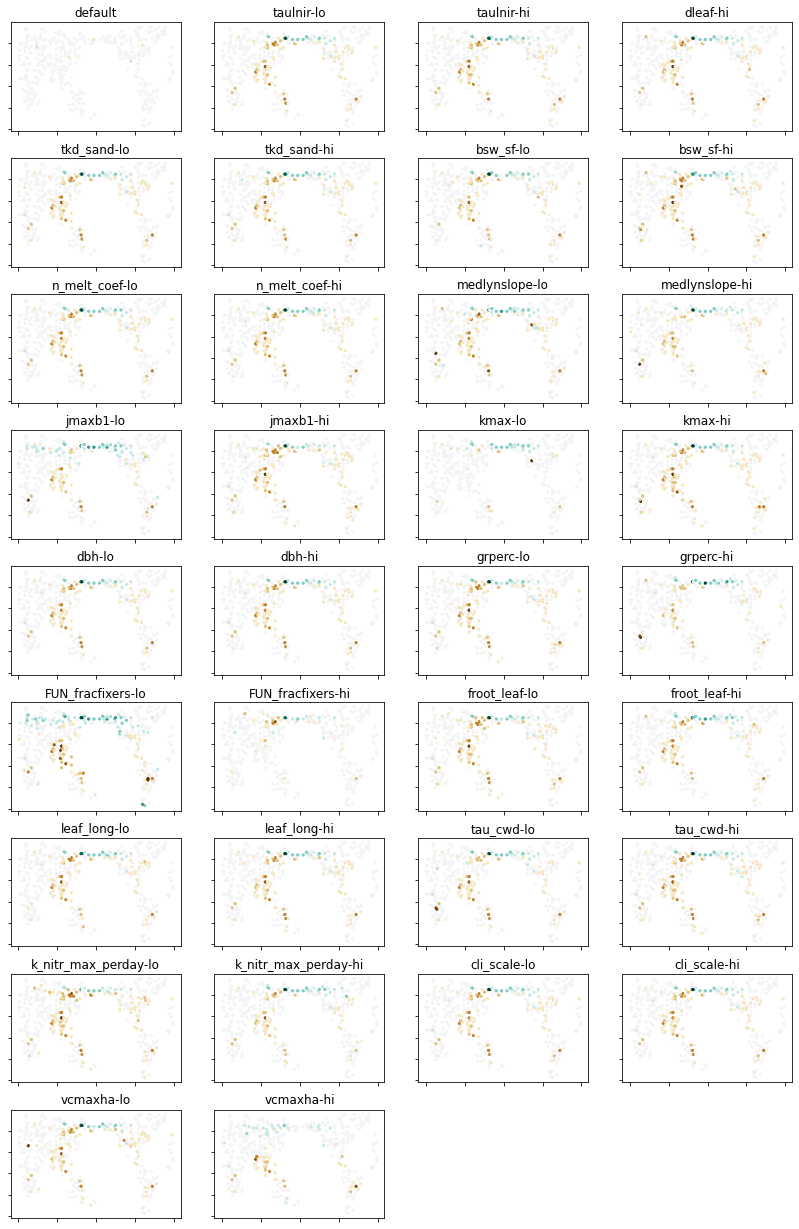

In [113]:
plt.figure(figsize=[14,22])
i=0
for ee in prod.ens.values:
    i+=1
    plt.subplot(9,4,i)
    plt.scatter(lons,lats,c=dc.sel(ens=ee),s=5,cmap=ccc,vmin=-200,vmax=200)
    plt.xticks(90*np.arange(5),'')
    plt.yticks(-60+30*np.arange(5),'')
    plt.title(p2[ee])
plt.subplots_adjust(hspace=0.25)

In [61]:
x1 = (24*60*60*365*step4.NPP.isel(time=t>31).mean(dim='time')).values

In [69]:
x2 = 24*60*60*(month_wts(10)*prod.NPP).groupby('time.year').sum().mean(dim='year').values

In [84]:
ix = abs(x2-x1)>10
la_diseq = (ix*la).sum(axis=1)
diseq = la_diseq/np.nansum(la)
diseq[1:].mean()

0.004590706558414795

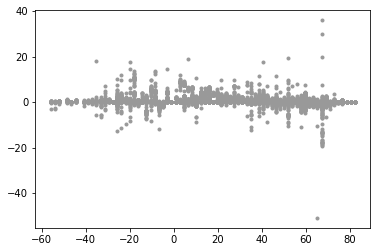

In [77]:
plt.plot(prod.grid1d_lat.sel(ens=0),(x2-x1).T,'.',color=[0.6,0.6,0.6]);

In [86]:
npp = 24*60*60*(month_wts(10)*prod.NPP).groupby('time.year').sum().mean(dim='year')

In [138]:
thedir = '/glade/scratch/djk2120/clm5ppe/ens002/hist/'
file = thedir+'PPEn08_I2000_OAAT0008.clm2.h0.0001-01-01-00000.nc'
prod = xr.open_dataset(file)
nmonths = len(prod.time)
yr0 = prod['time.year'][0].values
prod['time'] =xr.cftime_range(str(yr0),periods=nmonths,freq='MS')

In [144]:
thedir = '/glade/scratch/djk2120/clm5ppe/ens002/histSTEP4/'
file = thedir+'PPEn08_I2000_OAAT0008_STEP4.clm2.h0.0001-01-01-00000.nc'
step4 = xr.open_dataset(file)

In [147]:
t = step4['time.year']
tec0 = step4.TOTECOSYSC.sel(gridcell=1).isel(time=t>1)

In [140]:
tec = prod.TOTECOSYSC.sel(gridcell=1).groupby('time.year').mean()

In [164]:
t0 = step4.TOTECOSYSC.isel(time=t>31).mean(dim='time')

In [165]:
t1 = (month_wts(10)/365*prod.TOTECOSYSC).groupby('time.year').sum().mean(dim='year')

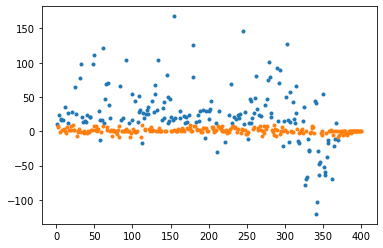

In [172]:
ix = abs(t1-t0)>10
ot = 1+np.arange(400)
plt.plot(ot[ix],(t1-t0)[ix],'.')
plt.plot(ot[~ix],(t1-t0)[~ix],'.')

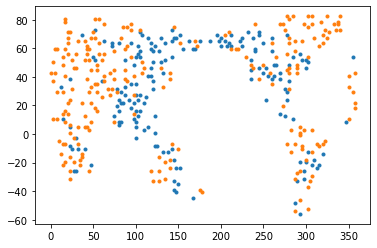

In [178]:
plt.plot(step4.grid1d_lon[ix],step4.grid1d_lat[ix],'.')
plt.plot(step4.grid1d_lon[~ix],step4.grid1d_lat[~ix],'.')

In [162]:
t0.values

array(15274.01, dtype=float32)

In [163]:
t1.values

array(15280.0505054)

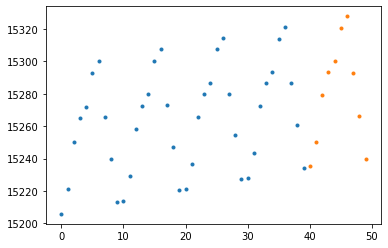

In [148]:
plt.plot(tec0,'.')
plt.plot(40+np.arange(10),tec,'.')

In [44]:
thedir = '/glade/scratch/oleson/archive/ctsm51c6_PPEn08ctsm51d023_2deg_GSWP3V1_Sparse400_2000_step4/lnd/hist/'
files = sorted(glob.glob(thedir+'*.h0.*'))

In [49]:
step4a = xr.concat([xr.open_dataset(file)['TOTECOSYSC'] for file in files[-240:-120]],dim='time')

In [45]:
step4 = xr.concat([xr.open_dataset(file)['TOTECOSYSC'] for file in files[-120:]],dim='time')

In [53]:
tec_step4a = step4a.mean(dim='time').values
tec_step4  = step4.mean(dim='time').values

In [55]:
dt = tec_step4-tec_step4a

In [75]:
ds = xr.open_dataset(files[0])

In [64]:
la = (ds.area*ds.landfrac).values

In [65]:
ix = abs(dt)>10

In [71]:
ix.sum()/400

0.0275

In [69]:
diseq = la[ix].sum()/np.nansum(la)
diseq

0.027824908

In [76]:
thedir  = '/glade/u/home/forrest/ppe_representativeness/output_v4/'
thefile = 'clusters.clm51_PPEn02ctsm51d021_2deg_GSWP3V1_leafbiomassesai_PPE3_hist.annual+sd.400.nc'
ds2 = xr.open_dataset(thedir+thefile)

In [94]:
lasparse = (ds2.area*ds2.landfrac).values

In [97]:
ladiseq = 0
for i in range(96):
    for j in range(144):
        if ix[i,j]:
            cc  = ds2.cclass[i,j].values
            ixc = (ds2.cclass==cc).values
            ladiseq = ladiseq+lasparse[ixc].sum()

0.030848116777689102

In [104]:
thedir = '/glade/scratch/djk2120/ctsm51c6_PPEn08ctsm51d023_2deg_GSWP3V1_Sparse400_2000_step4/run/'
file = thedir+'ctsm51c6_PPEn08ctsm51d023_2deg_GSWP3V1_Sparse400_2000_step4.clm2.h0.0001-01-01-00000.nc'
step4 = xr.open_dataset(file)

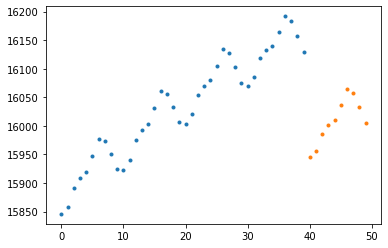

In [131]:
t = step4['time.year']
tec = step4.TOTECOSYSC.sel(gridcell=1).isel(time=t>1)
plt.plot(np.arange(40),tec,'.')
plt.plot(40+np.arange(10),tec2,'.')


In [129]:
tec2 = prod.TOTECOSYSC.sel(gridcell=1).groupby('time.year').mean()
tec2

<xarray.DataArray 'TOTECOSYSC' (year: 10)>
array([15944.94 , 15956.077, 15986.515, 16001.484, 16010.294, 16035.788,
       16063.985, 16057.89 , 16032.397, 16004.856], dtype=float32)
Coordinates:
  * year     (year) int64 2005 2006 2007 2008 2009 2010 2011 2012 2013 2014

In [109]:
ix = step4['time.year']>31
tec_step4 = step4.TOTECOSYSC.isel(time=ix).mean(dim='time').compute()

In [126]:
thedir = '/glade/scratch/djk2120/ctsm51c6_PPEn08ctsm51d023_2deg_GSWP3V1_Sparse400_2000/run/'
file = thedir+'ctsm51c6_PPEn08ctsm51d023_2deg_GSWP3V1_Sparse400_2000.clm2.h0.2005-02-01-00000.nc'
prod = xr.open_dataset(file)


In [113]:
dt = tec_prod.values-tec_step4.values
ix = abs(dt)>10

In [114]:
ix.sum()

240

In [42]:
thedir = '/glade/scratch/oleson/archive/ctsm51c6_PPEn08ctsm51d023_2deg_GSWP3V1_Sparse400_2000/lnd/hist/'
files = sorted(glob.glob(thedir+'*.h0.*'))
prod = xr.concat([xr.open_dataset(file)['TOTECOSYSC'] for file in files[:120]],dim='time')

In [43]:
prod

<xarray.DataArray 'TOTECOSYSC' (time: 120, gridcell: 400)>
array([[2.3173426e+04, 1.5919380e+04, 2.6219016e+04, ..., 4.0921268e+00,
        7.0627894e+00, 0.0000000e+00],
       [2.3231457e+04, 1.5962947e+04, 2.6298469e+04, ..., 4.0921268e+00,
        7.0627894e+00, 0.0000000e+00],
       [2.3250299e+04, 1.5982241e+04, 2.6345172e+04, ..., 4.0921268e+00,
        7.0627894e+00, 0.0000000e+00],
       ...,
       [2.3004785e+04, 1.5769082e+04, 2.5948771e+04, ..., 4.0921268e+00,
        7.0627894e+00, 0.0000000e+00],
       [2.3036295e+04, 1.5806688e+04, 2.6032826e+04, ..., 4.0921268e+00,
        7.0627894e+00, 0.0000000e+00],
       [2.3100305e+04, 1.5856120e+04, 2.6125570e+04, ..., 4.0921268e+00,
        7.0627894e+00, 0.0000000e+00]], dtype=float32)
Coordinates:
  * time     (time) object 2005-02-01 00:00:00 ... 2015-01-01 00:00:00
Dimensions without coordinates: gridcell
Attributes:
    long_name:     total ecosystem carbon, incl veg but excl cpool and produc...
    units:         gC/m^2
    cell_methods:  time: mean

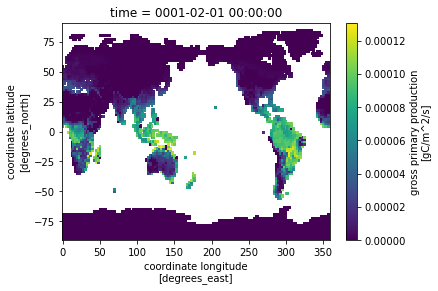

In [41]:
x.GPP.plot()

In [36]:
tec_prod = prod.mean(dim='time').compute()

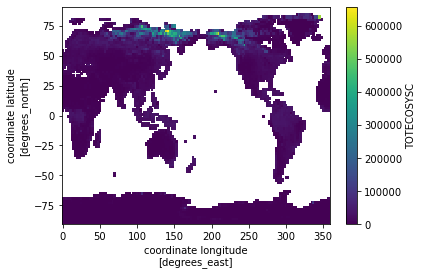

In [37]:
tec_prod.plot()

In [10]:
members = ['OAAT'+str(i).zfill(4) for i in range(35)]
members.remove('OAAT0003')

In [6]:
thedir = '/glade/scratch/djk2120/clm5ppe/ens002/histSTEP3/'
files = [glob.glob(thedir+'*'+member+'*.h0.*')[0] for member in members]
ds0 = xr.open_mfdataset(files,combine='nested',concat_dim='ens')

In [11]:
thedir = '/glade/scratch/djk2120/clm5ppe/ens002/histSTEP4/'
files = [glob.glob(thedir+'*'+member+'*.h0.*')[0] for member in members]
ds1 = xr.open_mfdataset(files,combine='nested',concat_dim='ens')

In [12]:
thedir = '/glade/scratch/djk2120/clm5ppe/ens002/hist/'
files = [glob.glob(thedir+'*'+member+'*.h0.*')[0] for member in members]
ds2 = xr.open_mfdataset(files,combine='nested',concat_dim='ens')
nmonths = len(ds2.time)
yr0 = ds2['time.year'][0].values
ds2['time'] =xr.cftime_range(str(yr0),periods=nmonths,freq='MS')

In [54]:
p2[20]

'FUN_fracfixers-lo'

In [138]:
ds = xr.Dataset()
ann_data = np.zeros([34,130,400])
fields = ['TOTVEGC','TOTECOSYSC','TOTSOMC','TOTSOMC_1m']
for field in fields:
    ix = np.arange(80)
    ixt = ds0['time.year']>1
    ann_data[:,ix,:]=ds0[field].isel(time=ixt)
    ix = 80+np.arange(40)
    ixt = ds1['time.year']>1
    ann_data[:,ix,:]=ds1[field].isel(time=ixt)
    ix = 120+np.arange(10)
    mth_wts = month_wts(10)/365
    ann_data[:,ix,:]=(mth_wts*ds2[field]).groupby('time.year').sum().transpose('ens','year','gridcell')

    da = xr.DataArray(ann_data,
                      coords=[('ens',np.arange(34)),
                              ('time',1+np.arange(130)),
                              ('gridcell',np.arange(400))],
                      name=field
                     )
    da.attrs = ds1[field].attrs
    ds[field] = da.copy(deep=True)
ds['keys'] = xr.DataArray(members,dims='ens')

In [48]:
ds

<xarray.Dataset>
Dimensions:     (ens: 34, gridcell: 400, time: 130)
Coordinates:
  * ens         (ens) int64 0 1 2 3 4 5 6 7 8 9 ... 25 26 27 28 29 30 31 32 33
  * time        (time) int64 1 2 3 4 5 6 7 8 ... 123 124 125 126 127 128 129 130
  * gridcell    (gridcell) int64 0 1 2 3 4 5 6 7 ... 393 394 395 396 397 398 399
Data variables:
    TOTVEGC     (ens, time, gridcell) float64 4.514e-05 3.625e-05 ... 0.0 0.0
    TOTECOSYSC  (ens, time, gridcell) float64 4.514e-05 3.625e-05 ... 0.0 0.0
    GPP         (ens, time, gridcell) float64 4.514e-05 3.625e-05 ... 0.0 0.0
    keys        (ens) <U8 'OAAT0000' 'OAAT0001' ... 'OAAT0033' 'OAAT0034'

In [49]:
la = xr.open_dataset('sparsegrid_landarea.nc').landarea

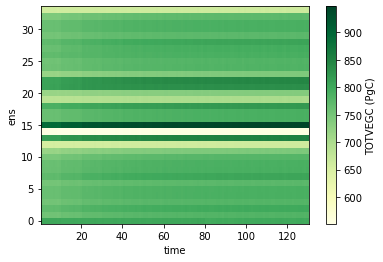

In [165]:
tvc = (1e-9*(la*ds.TOTVEGC).sum(dim='gridcell')).compute()
tvc.plot(cbar_kwargs={'label':'TOTVEGC (PgC)'},cmap='YlGn');

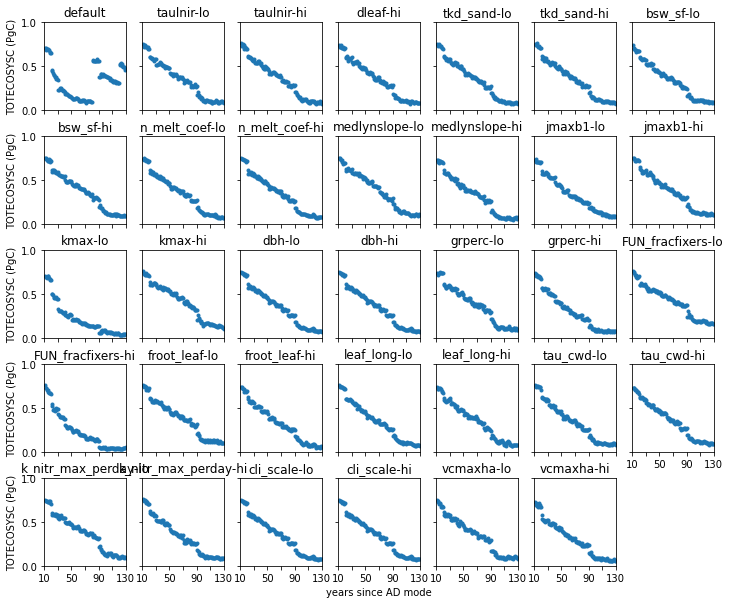

In [105]:
plt.figure(figsize=[12,10])
for i in range(nens):
    plt.subplot(5,7,i+1)
    plt.plot(11+np.arange(120),diseq[i,:],'.')
    plt.ylim([0,1])
    plt.xlim([10,130])
    plt.title(p2[i])
    
    if i%7==0:
        plt.yticks(np.arange(3)/2)
        plt.ylabel('TOTECOSYSC (PgC)')
    else:
        plt.yticks(np.arange(3)/2,'')
        
    if i>26:
        plt.xticks(10+20*np.arange(7),[10,'',50,'',90,'',130])
    else:
        plt.xticks(10+20*np.arange(7),'')
    if i==31:
        plt.xlabel('years since AD mode')
plt.subplots_adjust(hspace=0.3)



In [166]:
ix1 = 111+np.arange(10)
ix2 = 121+np.arange(10)
tec1 = ds.TOTECOSYSC.sel(time=ix1).mean(dim='time')
tec2 = ds.TOTECOSYSC.sel(time=ix2).mean(dim='time')
dtec = tec2-tec1
lasum = la.sum()
la_tiled = np.tile(la,[34,1])


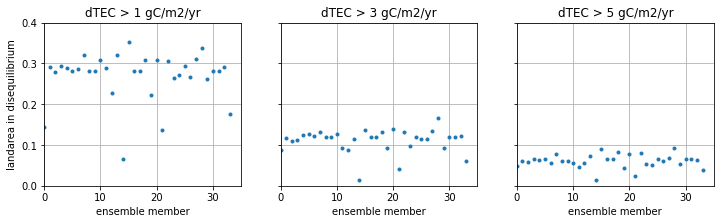

In [167]:
i=0
plt.figure(figsize=[12,3])
for thresh in 1+2*np.arange(3):
    i +=1
    ix_dtec = abs(dtec>10*thresh)
    tec_diseq = (ix_dtec*la_tiled).sum(dim='gridcell')/lasum
    plt.subplot(1,3,i)
    plt.plot(tec_diseq,'.')
    plt.xlabel('ensemble member')

    plt.title('dTEC > '+str(thresh)+' gC/m2/yr');
    plt.ylim([0,0.4]);
    plt.xlim([0,35])
    if i==1:
        plt.ylabel('landarea in disequilibrium')
        plt.yticks(np.arange(5)/10)
    else:
        plt.yticks(np.arange(5)/10,'')
    plt.grid()